In [36]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [ ]:
base_path = '/Users/dmartins/Documents/GitHub/spine-population-modeling/clean_data'
file_paths = sorted([os.path.join(base_path, x) for x in os.listdir('./clean_data')])
file_paths = [x for x in file_paths if 'DS_Store' not in x]

if isinstance(file_paths, str):
    file_paths = [file_paths]

# Initialize an empty list to accumulate all the transitions across files
all_transitions = []

# Iterate through each file
for file_path in file_paths:
    # Read the DataFrame from the file
    df = pd.read_hdf(file_path)
    df = df.replace('filopodia', 'filopodium')
    
    # Ensure the 'stage' column exists
    if 'stage' not in df.columns:
        raise ValueError(f"'stage' column is missing in {file_path}.")
    
    # Iterate through the rows of the dataframe and check for D -> P transitions
    for i in range(0, len(df)-1):
        # Look for transitions from 'D' to 'P'
        if df.iloc[i]['stage'] == 'D' and df.iloc[i+1]['stage'] == 'P':
            # Collect the string values for transition
            for col in [x for x in df.columns.values if x!='hrs' or x!='stage']:
                transition_pair = (df.iloc[i][col], df.iloc[i+1][col])
                all_transitions.append(transition_pair)


In [ ]:
state_options = ['NS','filopodium','thin','stubby','mushroom']
state_to_idx = {s: i for i, s in enumerate(state_options)}

# Initialize count matrix
count_matrix = np.zeros((5, 5), dtype=np.float64)

# Fill the count matrix
for from_state, to_state in all_transitions:
    # Skip any transitions that do not match expected naming
    if (from_state not in state_options) or (to_state not in state_options):
        continue
    i = state_to_idx[from_state]
    j = state_to_idx[to_state]
    count_matrix[i, j] += 1

# Normalize rows to get transition probabilities
row_sums = count_matrix.sum(axis=1, keepdims=True)
transition_matrix = np.divide(count_matrix, row_sums, where=row_sums != 0)

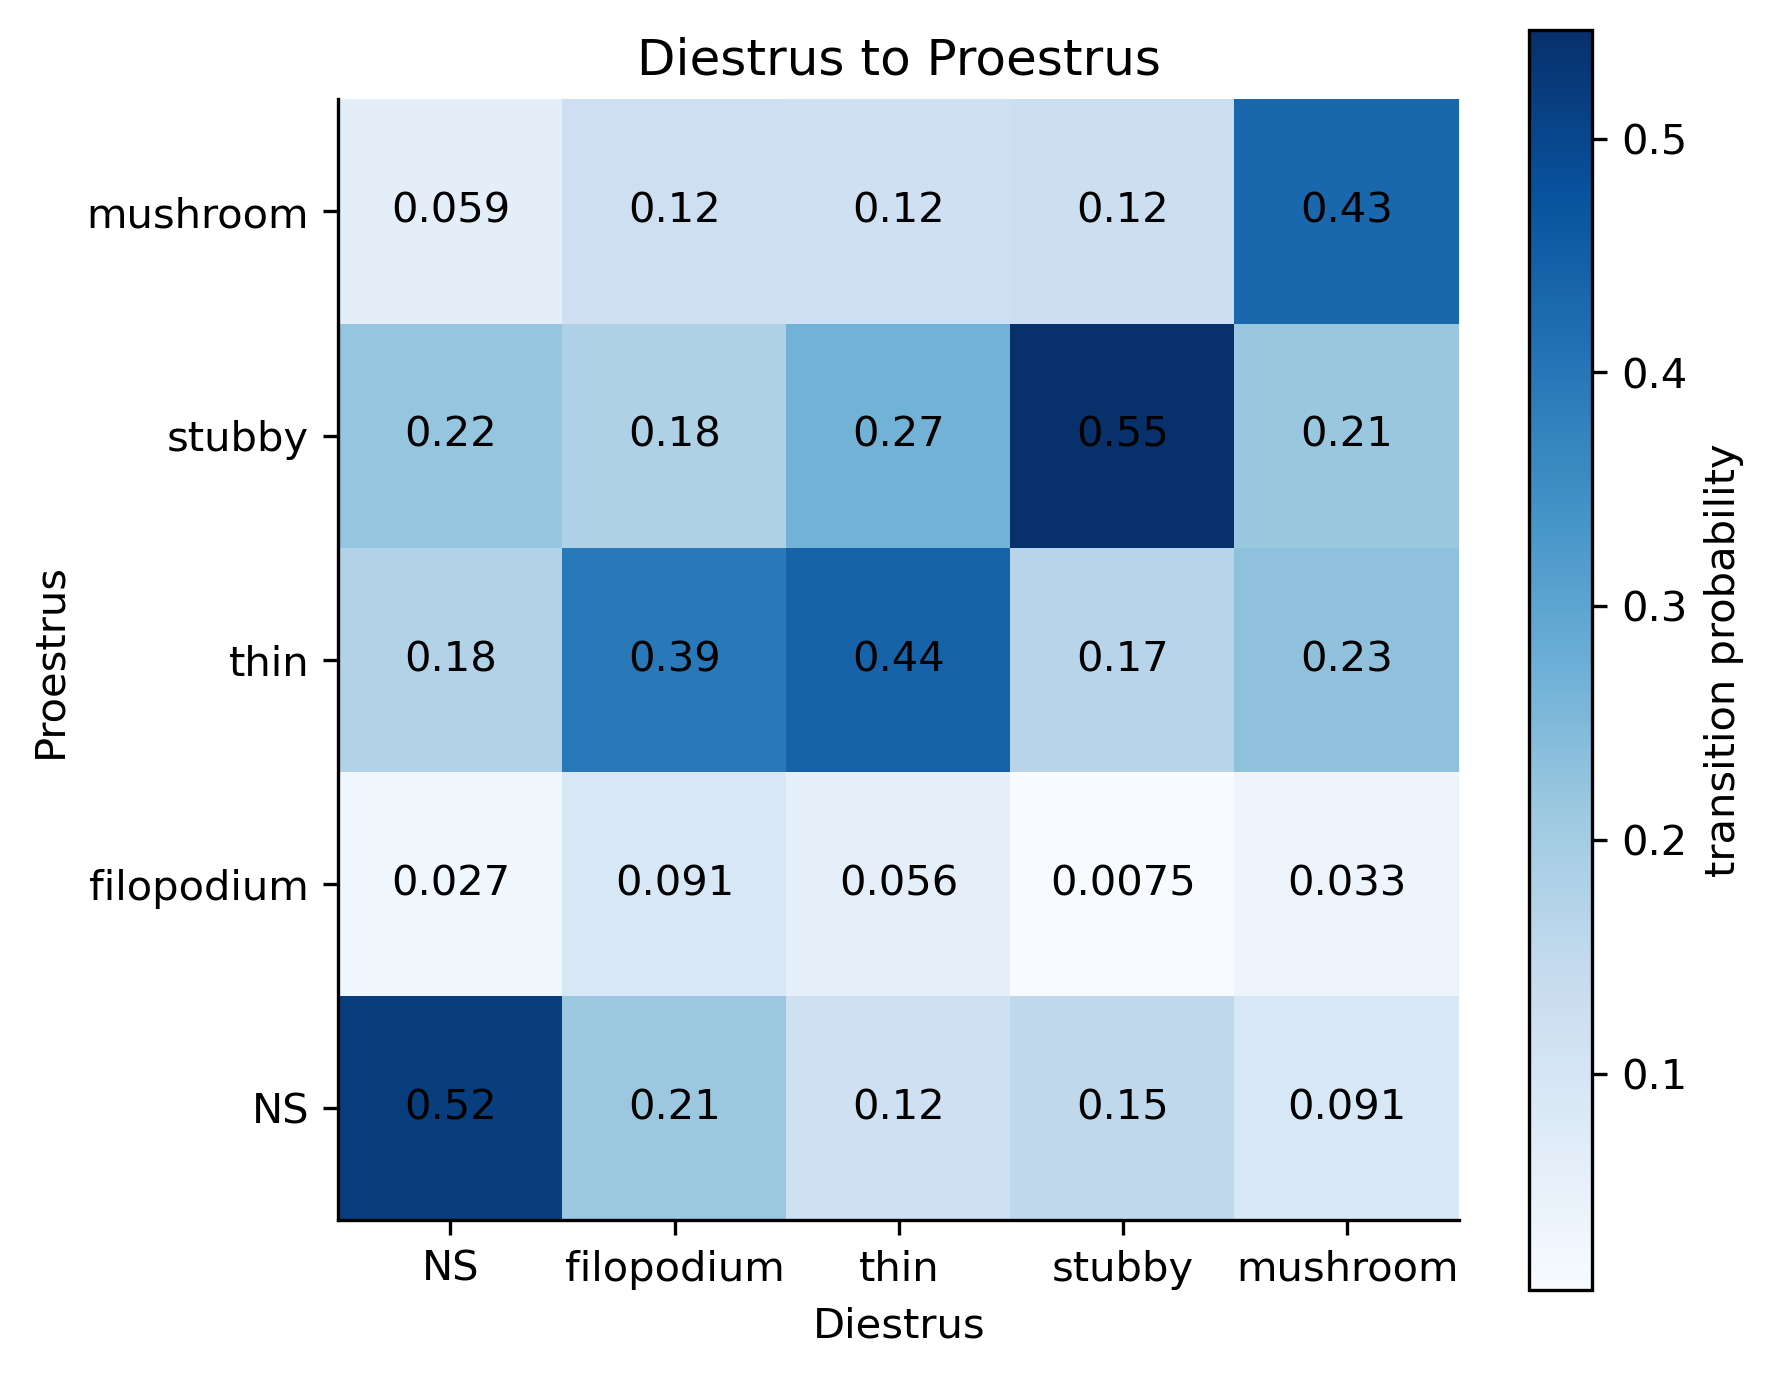

In [37]:
fig = plt.figure(figsize=(6,5),dpi=300)
plt.imshow(transition_matrix.T, cmap='Blues', origin='lower')
for i in range(transition_matrix.shape[1]):
    for j in range(transition_matrix.shape[0]):
        text = plt.text(j, i, '{:.2}'.format(transition_matrix[j,i]), ha="center", va="center", color="k")
plt.xticks(range(len(state_options)), labels=state_options)
plt.yticks(range(len(state_options)), labels=state_options)
plt.title('Diestrus to Proestrus')
plt.xlabel('Diestrus')
plt.ylabel('Proestrus')
plt.colorbar(label='transition probability')
plt.tight_layout()
fig.savefig('DtoP_transition.svg')

In [ ]:
transition_matrix.T

array([[0.51740506, 0.21212121, 0.11888112, 0.15485075, 0.09053498],
       [0.02689873, 0.09090909, 0.05594406, 0.00746269, 0.03292181],
       [0.17563291, 0.39393939, 0.44055944, 0.16604478, 0.23045267],
       [0.22151899, 0.18181818, 0.26573427, 0.54664179, 0.21399177],
       [0.0585443 , 0.12121212, 0.11888112, 0.125     , 0.43209877]])

In [34]:
np.save('transition_matrix_DtoP.npy', transition_matrix.T)